### Import Libraries

In [20]:
import requests
import json
from pprint import pprint
import pandas as pd
import statsmodels.tsa.stattools as sts

### Extract Sample data

In [2]:
#url = "https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords=MTN&apikey=***********"
#r = requests.get(url)
#data = r.json()
#pprint(data)

In [3]:
# filename = "MTN.json"
# url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MTNOY&outputsize=compact&apikey=************"
# r = requests.get(url)
# data = r.json()
# with open(filename, mode="w") as f:
#    json.dump(data)

In [4]:
filename = "MTN.json"
with open(filename) as f:
    data = json.load(f)

data

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
  '2. Symbol': 'MTNOY',
  '3. Last Refreshed': '2024-08-23',
  '4. Output Size': 'Compact',
  '5. Time Zone': 'US/Eastern'},
 'Time Series (Daily)': {'2024-08-23': {'1. open': '5.2700',
   '2. high': '5.4400',
   '3. low': '5.2400',
   '4. close': '5.4000',
   '5. volume': '9404'},
  '2024-08-22': {'1. open': '5.0910',
   '2. high': '5.1000',
   '3. low': '4.9800',
   '4. close': '5.0220',
   '5. volume': '9686'},
  '2024-08-21': {'1. open': '5.0350',
   '2. high': '5.0800',
   '3. low': '5.0050',
   '4. close': '5.0100',
   '5. volume': '3612'},
  '2024-08-20': {'1. open': '5.1000',
   '2. high': '5.1000',
   '3. low': '4.9900',
   '4. close': '5.0600',
   '5. volume': '16192'},
  '2024-08-19': {'1. open': '4.9900',
   '2. high': '5.1000',
   '3. low': '4.9900',
   '4. close': '5.0800',
   '5. volume': '14701'},
  '2024-08-16': {'1. open': '4.8600',
   '2. high': '5.0000',
   '3. low': '4.8600',
   '

### Data Pre-processing

In [5]:
data.keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

In [6]:
data["Time Series (Daily)"]

{'2024-08-23': {'1. open': '5.2700',
  '2. high': '5.4400',
  '3. low': '5.2400',
  '4. close': '5.4000',
  '5. volume': '9404'},
 '2024-08-22': {'1. open': '5.0910',
  '2. high': '5.1000',
  '3. low': '4.9800',
  '4. close': '5.0220',
  '5. volume': '9686'},
 '2024-08-21': {'1. open': '5.0350',
  '2. high': '5.0800',
  '3. low': '5.0050',
  '4. close': '5.0100',
  '5. volume': '3612'},
 '2024-08-20': {'1. open': '5.1000',
  '2. high': '5.1000',
  '3. low': '4.9900',
  '4. close': '5.0600',
  '5. volume': '16192'},
 '2024-08-19': {'1. open': '4.9900',
  '2. high': '5.1000',
  '3. low': '4.9900',
  '4. close': '5.0800',
  '5. volume': '14701'},
 '2024-08-16': {'1. open': '4.8600',
  '2. high': '5.0000',
  '3. low': '4.8600',
  '4. close': '4.9900',
  '5. volume': '16655'},
 '2024-08-15': {'1. open': '4.7701',
  '2. high': '4.8200',
  '3. low': '4.7700',
  '4. close': '4.8050',
  '5. volume': '14662'},
 '2024-08-14': {'1. open': '4.7000',
  '2. high': '4.7300',
  '3. low': '4.6905',
  '4

In [7]:
df_comp = pd.DataFrame(data["Time Series (Daily)"]).T

In [8]:
df_comp.describe()

,1. open,2. high,3. low,4. close,5. volume
count,100,100,100,100,100
unique,77,80,75,81,98
top,4.5000,4.7300,4.5100,4.4800,598250
freq,4,3,4,3,2


In [9]:
df_comp.dtypes

1. open      object
2. high      object
3. low       object
4. close     object
5. volume    object
dtype: object

In [10]:
df_comp.head()

,1. open,2. high,3. low,4. close,5. volume
2024-08-23,5.2700,5.4400,5.2400,5.4000,9404
2024-08-22,5.0910,5.1000,4.9800,5.0220,9686
2024-08-21,5.0350,5.0800,5.0050,5.0100,3612
2024-08-20,5.1000,5.1000,4.9900,5.0600,16192
2024-08-19,4.9900,5.1000,4.9900,5.0800,14701


In [11]:
for i in df_comp.columns:
    df_comp[i] = df_comp[i].astype(float)

In [12]:
df_comp.dtypes

1. open      float64
2. high      float64
3. low       float64
4. close     float64
5. volume    float64
dtype: object

In [13]:
df_comp = df_comp[::-1]

In [14]:
df = df_comp.copy()

In [15]:
del df["1. open"],df["2. high"],df["3. low"],df["5. volume"],

In [16]:
df.rename(columns= {"4. close":"mkt_price"}, inplace=True)

In [17]:
size = int(0.8 * len(df))
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [18]:
df_train.describe()

,mkt_price
count,80.000000
mean,4.624336
std,0.284637
min,4.102000
25%,4.431500
50%,4.587000
75%,4.778750
max,5.290000


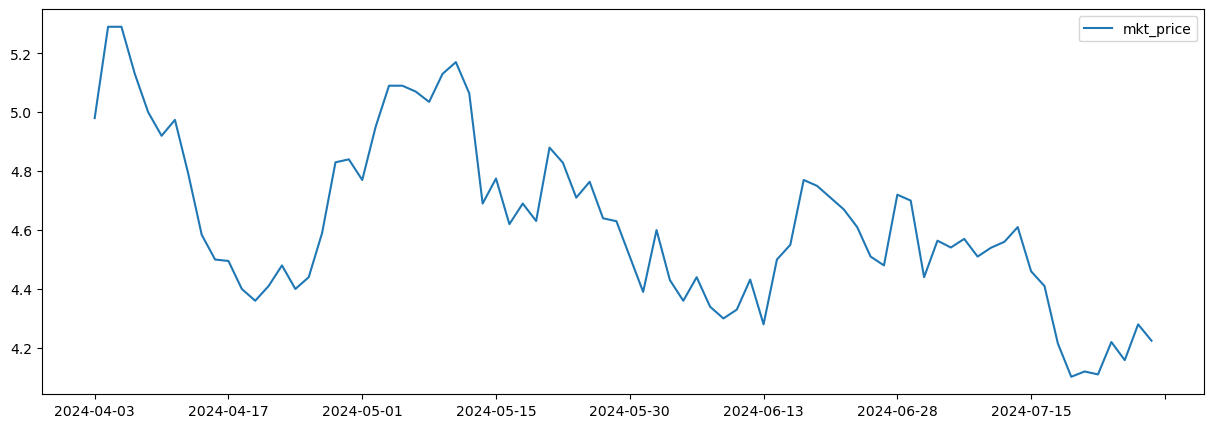

In [19]:
df_train.plot(figsize=(15,5));